In [1]:
from np_to_tfrecord import np_to_tfrecords
import numpy as np
import tensorflow as tf
from SolvePossion_FD import *
import os
import json
import functools
tf.enable_eager_execution()

2022-11-22 09:41:27.834220: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
W1122 09:41:29.503468 140736115068528 module_wrapper.py:139] From /tmp/ipykernel_1978399/707491456.py:8: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.



# Generate Data

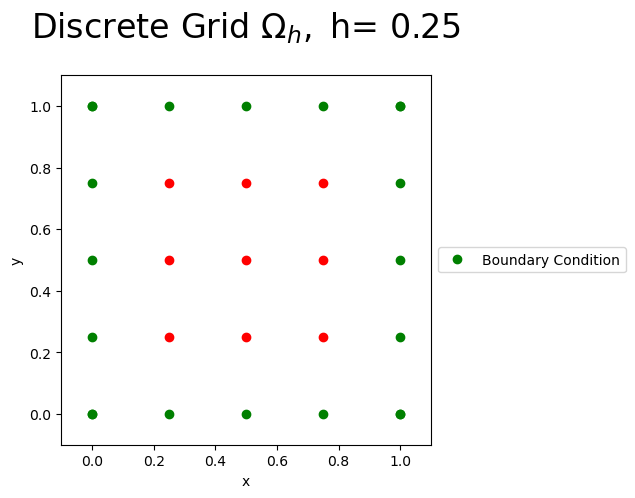

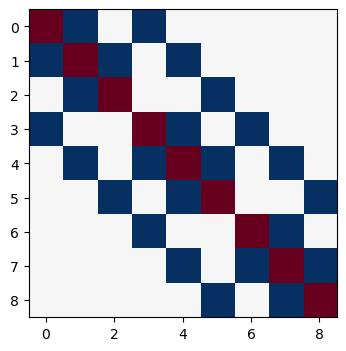

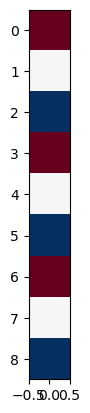

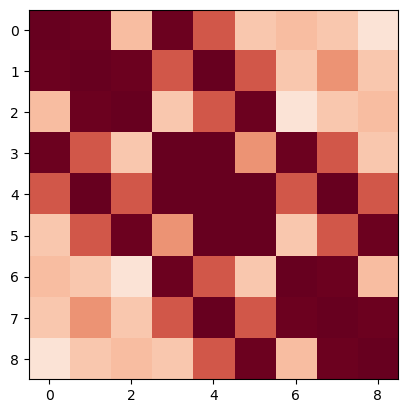

N = 5, h = 0.25000 ---->  error = 0.008494688418465724


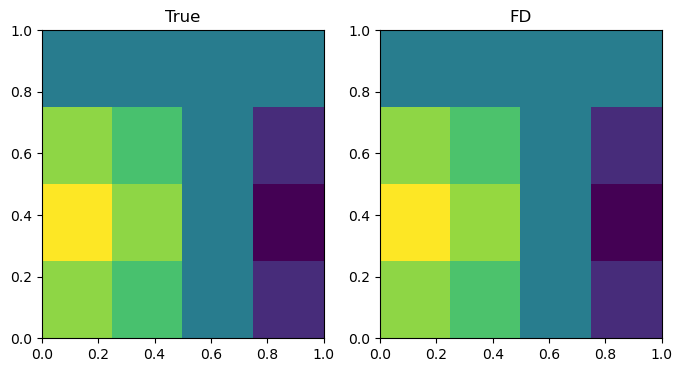

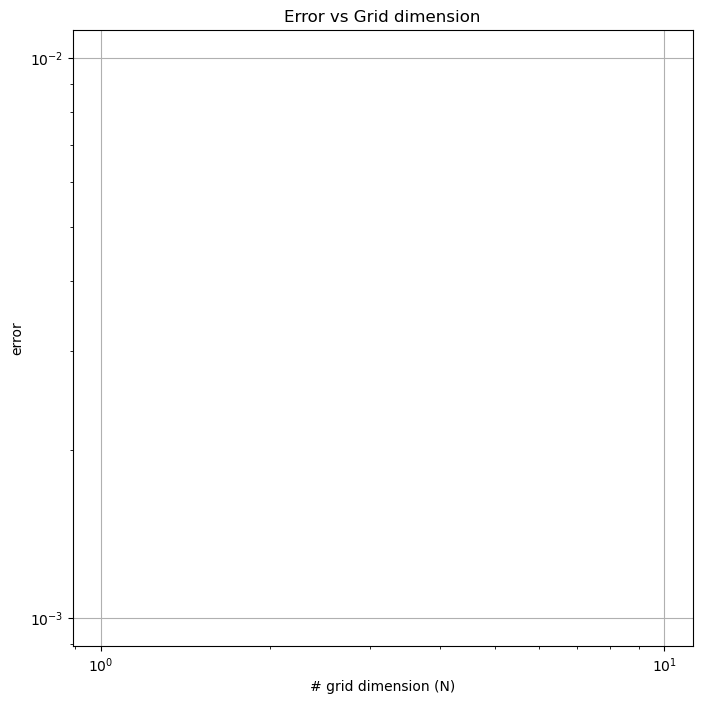

In [2]:
A,b,coordinates,errors,labels = main(5,6)

In [3]:
int_type = np.int64

cells = np.ones((1,32,3), dtype=int_type)
mesh_pos = np.ones((1,25,2), dtype=np.float32)
node_type = np.ones((1,25,1), dtype=int_type)
temperature = np.zeros((2,25,1), dtype=np.float32)

cells[None,:,:] = np.array([
    [0, 1, 6],
    [1, 2, 7],
    [2, 3, 8],
    [3, 4, 9],
    [5, 6, 11],
    [6, 7, 12],
    [7, 8, 13],
    [8, 9, 14],
    [10, 11, 16],
    [11, 12, 17],
    [12, 13, 18],
    [13, 14, 19],
    [15, 16, 21],
    [16, 17, 22],
    [17, 18, 23],
    [18, 19, 24],
    [0, 6, 5],
    [1, 7, 6],
    [2, 8, 7],
    [3, 9, 8],
    [5, 11, 10],
    [6, 12, 11],
    [7, 13, 12],
    [8, 14, 13],
    [10, 16, 15],
    [11, 17, 16],
    [12, 18, 17],
    [13, 19, 18],
    [15, 21, 20],
    [16, 22, 21],
    [17, 23, 22],
    [18, 24, 23]
], dtype=int_type)


mesh_pos[None,:,:] = coordinates

node_type[None,:,:] = np.array([
    [6],
    [6],
    [6],
    [6],
    [6],
    [6],
    [0],
    [0],
    [0],
    [6],
    [6],
    [0],
    [0],
    [0],
    [6],
    [6],
    [0],
    [0],
    [0],
    [6],
    [6],
    [6],
    [6],
    [6],
    [6],
    
], dtype = int_type)

labels = labels.astype(np.float32)
temperature[0,:,:] = np.array([
    [labels[0]],
    [labels[1]],
    [labels[2]],
    [labels[3]],
    [labels[4]],
    [labels[5]],
    [0],
    [0],
    [0],
    [labels[9]],
    [labels[10]],
    [0],
    [0],
    [0],
    [labels[14]],
    [labels[15]],
    [0],
    [0],
    [0],
    [labels[19]],
    [labels[20]],
    [labels[21]],
    [labels[22]],
    [labels[23]],
    [labels[24]],
    
], dtype = np.float32)

temperature[1,:,:] = labels

In [4]:
print(mesh_pos)

[[[0.   1.  ]
  [0.25 1.  ]
  [0.5  1.  ]
  [0.75 1.  ]
  [1.   1.  ]
  [0.   0.75]
  [0.25 0.75]
  [0.5  0.75]
  [0.75 0.75]
  [1.   0.75]
  [0.   0.5 ]
  [0.25 0.5 ]
  [0.5  0.5 ]
  [0.75 0.5 ]
  [1.   0.5 ]
  [0.   0.25]
  [0.25 0.25]
  [0.5  0.25]
  [0.75 0.25]
  [1.   0.25]
  [0.   0.  ]
  [0.25 0.  ]
  [0.5  0.  ]
  [0.75 0.  ]
  [1.   0.  ]]]


In [5]:
print('cells_shape', cells.shape, 'cells_dtype ', cells.dtype)
print('mesh_pos', mesh_pos.shape, 'mesh_pos_dtype ', mesh_pos.dtype)
print('node_type', node_type.shape, 'node_type_dtype ', node_type.dtype)
print('temperature', temperature.shape, 'temperature_dtype ', temperature.dtype)

cells_shape (1, 32, 3) cells_dtype  int64
mesh_pos (1, 25, 2) mesh_pos_dtype  float32
node_type (1, 25, 1) node_type_dtype  int64
temperature (2, 25, 1) temperature_dtype  float32


# Write TF Record File 

In [6]:
def np_to_tfrecords(data, output_file):
    
    # write records to a tfrecords file
    writer = tf.io.TFRecordWriter(output_file)
    m = data['temperature'].shape[0]
    for i in range(m):
        #print('i', i)
        # Loop through all the features you want to write
        feature = {}
        for name, value in data.items():
          #print('name: ',name)
          #print('value: ',value)
          if name=='temperature':
              value = value[i]
              #print('value[i]: ', value,'\n')
          # print(name)
          # Feature contains a map of string to feature proto objects
          if value.dtype == "float32":
            feature[name] = tf.train.Feature(float_list=tf.train.FloatList(value=value.flatten()))
            #feature[name] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.flatten().tobytes()]))
          elif value.dtype == "int32" or value.dtype == "int64":
            feature[name] = tf.train.Feature(int64_list=tf.train.Int64List(value=value.flatten()))
            #feature[name] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.flatten().tobytes()]))
          else:
              raise ValueError('invalid data format: '+str(value.dtype))
        
        print('feature: ',feature)
        # Construct the Example proto object
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        # print(example)
    
        # Serialize the example to a string
        serialized = example.SerializeToString()
    
        # write the serialized objec to the disk
        writer.write(serialized)
    writer.close()

In [7]:
data = {
    'cells':cells,
    'mesh_pos':mesh_pos,
    'node_type':node_type,
    'temperature':temperature
}
os.remove("/gpfs/u/scratch/ODLC/ODLCsfsh/deepmind-research/meshgraphnets/data/cylinder_flow/train.tfrecord")
np_to_tfrecords(data, "/gpfs/u/scratch/ODLC/ODLCsfsh/deepmind-research/meshgraphnets/data/cylinder_flow/train.tfrecord")

feature:  {'cells': int64_list {
  value: 0
  value: 1
  value: 6
  value: 1
  value: 2
  value: 7
  value: 2
  value: 3
  value: 8
  value: 3
  value: 4
  value: 9
  value: 5
  value: 6
  value: 11
  value: 6
  value: 7
  value: 12
  value: 7
  value: 8
  value: 13
  value: 8
  value: 9
  value: 14
  value: 10
  value: 11
  value: 16
  value: 11
  value: 12
  value: 17
  value: 12
  value: 13
  value: 18
  value: 13
  value: 14
  value: 19
  value: 15
  value: 16
  value: 21
  value: 16
  value: 17
  value: 22
  value: 17
  value: 18
  value: 23
  value: 18
  value: 19
  value: 24
  value: 0
  value: 6
  value: 5
  value: 1
  value: 7
  value: 6
  value: 2
  value: 8
  value: 7
  value: 3
  value: 9
  value: 8
  value: 5
  value: 11
  value: 10
  value: 6
  value: 12
  value: 11
  value: 7
  value: 13
  value: 12
  value: 8
  value: 14
  value: 13
  value: 10
  value: 16
  value: 15
  value: 11
  value: 17
  value: 16
  value: 12
  value: 18
  value: 17
  value: 13
  value: 19
  value

# Read TF Record file

In [8]:
# def parse(proto,meta):
#     return tf.parse_single_example(proto, features={
#        'cells': tf.FixedLenFeature([1,32,3], tf.int64, default_value=tf.zeros((1,32,3),dtype=tf.int64)),
#        'mesh_pos': tf.FixedLenFeature([1,25,2], tf.float32, default_value=tf.zeros((1,25,2),dtype=tf.float32)),
#        'node_type': tf.FixedLenFeature([1,25,1], tf.int64, default_value=tf.zeros((1,25,1),dtype=tf.int64)),
#        'temperature': tf.FixedLenFeature([2,25,1], tf.float32, default_value=tf.zeros((2,25,1),dtype=tf.float32)),
#    })

# def parse(proto,meta):
#     return tf.parse_single_example(proto, features={
#        'cells': tf.io.VarLenFeature(tf.int64),
#        'mesh_pos': tf.io.VarLenFeature(tf.float32),
#        'node_type': tf.io.VarLenFeature(tf.int64),
#        'temperature': tf.io.VarLenFeature(tf.float32)
#    })


def parse(proto,meta):
    features = tf.parse_single_example(proto, features={
       'cells': tf.io.VarLenFeature(tf.int64),
       'mesh_pos': tf.io.VarLenFeature(tf.float32),
       'node_type': tf.io.VarLenFeature(tf.int64),
       'temperature': tf.io.VarLenFeature(tf.float32)
    })
    out = {}
    
    for key, field in meta['features'].items():
        print('key: ',key)
        print('field: ',field)
        data = features[key].values
        print('data: ',data,'\n')
        if key=='cells':
            data = tf.reshape(data, [1,32,3])
        elif key=='mesh_pos':
            data = tf.reshape(data, [1,25,2])
        elif key=='node_type':
            data = tf.reshape(data, [1,25,1])
        elif key=='temperature':
            data = tf.reshape(data, [1,25,1])
            
        if field['type'] == 'static':
            data = tf.tile(data, [meta['trajectory_length'], 1, 1])
        elif field['type'] != 'dynamic':
            raise ValueError('invalid data format')
        out[key]=data
    
    return out

# def _parse(proto, meta):
#   """Parses a trajectory from tf.Example."""
#   feature_lists = {k: tf.io.VarLenFeature(tf.string)
#                    for k in meta['field_names']}
#   features = tf.io.parse_single_example(proto, feature_lists)
#   out = {}
#   for key, field in meta['features'].items():
#     data = tf.io.decode_raw(features[key].values, getattr(tf, field['dtype']))
#     print('data: ',data)
#     data = tf.reshape(data, (1,32,3))
#     if field['type'] == 'static':
#       data = tf.tile(data, [meta['trajectory_length'], 1, 1])
#     elif field['type'] == 'dynamic_varlen':
#       length = tf.io.decode_raw(features['length_'+key].values, tf.int32)
#       length = tf.reshape(length, [-1])
#       data = tf.RaggedTensor.from_row_lengths(data, row_lengths=length)
#     elif field['type'] != 'dynamic':
#       raise ValueError('invalid data format')
#     out[key] = data
#   return out

In [9]:
def load_dataset(path, split):
  """Load dataset."""
  with open(os.path.join(path, 'meta.json'), 'r') as fp:
    meta = json.loads(fp.read())
  ds = tf.data.TFRecordDataset(os.path.join(path, split+'.tfrecord'))
  ds = ds.map(functools.partial(parse, meta=meta), num_parallel_calls=8)
  # ds = ds.prefetch(1)
  return ds

In [10]:
split = "train"
path = "/gpfs/u/scratch/ODLC/ODLCsfsh/deepmind-research/meshgraphnets/data/cylinder_flow"
dataset = load_dataset(path, split)

2022-11-22 09:41:31.028348: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-22 09:41:31.228417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla V100-SXM2-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0035:04:00.0
2022-11-22 09:41:31.230891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 1 with properties: 
name: Tesla V100-SXM2-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0035:05:00.0
2022-11-22 09:41:31.230914: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-11-22 09:41:31.234148: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-11-22 09:41:31.235327: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10


key:  cells
field:  {'type': 'static', 'shape': [1, 32, 3], 'dtype': 'int64'}
data:  Tensor("ParseSingleExample/ParseSingleExample:4", shape=(?,), dtype=int64) 

key:  mesh_pos
field:  {'type': 'static', 'shape': [1, 25, 2], 'dtype': 'float32'}
data:  Tensor("ParseSingleExample/ParseSingleExample:5", shape=(?,), dtype=float32) 

key:  node_type
field:  {'type': 'static', 'shape': [1, 25, 1], 'dtype': 'int64'}
data:  Tensor("ParseSingleExample/ParseSingleExample:6", shape=(?,), dtype=int64) 

key:  temperature
field:  {'type': 'dynamic', 'shape': [2, 25, 1], 'dtype': 'float32'}
data:  Tensor("ParseSingleExample/ParseSingleExample:7", shape=(?,), dtype=float32) 



In [11]:
iterator = iter(dataset)

positions = next(iterator)
print()
print(positions)
arrays = [np.array(positions[item]) for item in positions]
for array in arrays:
    print(array.shape)


{'cells': <tf.Tensor: id=53, shape=(2, 32, 3), dtype=int64, numpy=
array([[[ 0,  1,  6],
        [ 1,  2,  7],
        [ 2,  3,  8],
        [ 3,  4,  9],
        [ 5,  6, 11],
        [ 6,  7, 12],
        [ 7,  8, 13],
        [ 8,  9, 14],
        [10, 11, 16],
        [11, 12, 17],
        [12, 13, 18],
        [13, 14, 19],
        [15, 16, 21],
        [16, 17, 22],
        [17, 18, 23],
        [18, 19, 24],
        [ 0,  6,  5],
        [ 1,  7,  6],
        [ 2,  8,  7],
        [ 3,  9,  8],
        [ 5, 11, 10],
        [ 6, 12, 11],
        [ 7, 13, 12],
        [ 8, 14, 13],
        [10, 16, 15],
        [11, 17, 16],
        [12, 18, 17],
        [13, 19, 18],
        [15, 21, 20],
        [16, 22, 21],
        [17, 23, 22],
        [18, 24, 23]],

       [[ 0,  1,  6],
        [ 1,  2,  7],
        [ 2,  3,  8],
        [ 3,  4,  9],
        [ 5,  6, 11],
        [ 6,  7, 12],
        [ 7,  8, 13],
        [ 8,  9, 14],
        [10, 11, 16],
        [11, 12, 17],
      